# Imports and constants

In [1]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

from Metrics import compute_metrics, make_metric_plots
import visualizer.Viewer as vw
from models.time_series.anomaly.statistical.TimeSeriesAnomalyARIMA import TimeSeriesAnomalyARIMA
from reader.NABTimeSeriesReader import NABTimeSeriesReader

# DATASET 1: ambient_temperature_system_failure
# DATASET 2: nyc_taxi
DATASET_PATH = "data/dataset/"
DATASET = "nyc_taxi.csv"
PURE_DATA_KEY = "realKnownCause/nyc_taxi.csv"
GROUND_WINDOWS_PATH = "data/dataset/combined_windows.json"
CHECK_OVERFITTING = False
ALL_DATA = False

def preprocess(X) -> np.ndarray:
    return StandardScaler().fit_transform(X)

# Read the dataset and train-test split

In [2]:
reader = NABTimeSeriesReader(DATASET_PATH)
all_df = reader.read(DATASET_PATH + DATASET).get_dataframe()
training, test = reader.train_test_split(train_perc=0.37).get_train_test_dataframes()

# Data used to train
data = preprocess(np.array(training["value"]).reshape((training["value"].shape[0], 1)))
data_labels = training["target"]

# Data used to test
data_test = preprocess(np.array(test["value"]).reshape((test["value"].shape[0], 1)))
data_test_labels = test["target"]

# Dataframe used to evaluate
dataframe = test.copy()
dataframe["value"] = data_test

train = data

if CHECK_OVERFITTING:
    data_test = data
    data_test_labels = data_labels
    dataframe = training.copy()
    dataframe["value"] = data_test
elif ALL_DATA:
    data_test = preprocess(np.array(all_df["value"]).reshape(all_df["value"].shape[0], 1))
    data_test_labels = all_df["target"]
    dataframe = all_df.copy()
    dataframe["value"] = data_test

# Create model, classify and score

In [3]:
model = TimeSeriesAnomalyARIMA(scoring="difference",
                               endog=train,
                               order=(10, 0, 0),
                               seasonal_order=(0, 0, 0, 0),
                               trend="n")
model.fit(fit_params={"method":"innovations_mle",
                      "gls":True})

true_labels = data_test_labels

labels = model.classify(data_test.reshape((-1, 1)), data.reshape((-1, 1)))
scores = model.anomaly_score(data_test.reshape((-1, 1)), data.reshape((-1, 1)))

= Start of the model fit =
[2022/05/17 10:32:56] Execution: Start to learn the parameters
[2022/05/17 10:32:57] Execution: Parameters have been learnt
[2022/05/17 10:32:57] Execution: Start to compute predictions of the test set
[2022/05/17 10:32:57] Execution: Test set has been predicted
[2022/05/17 10:32:57] Execution: Start to compute prediction errors
[2022/05/17 10:32:57] Execution: Prediction errors have been computed
[2022/05/17 10:32:57] Execution: Start to compute the threshold on the validation data
[2022/05/17 10:32:57] Execution: Threshold has been computed
[2022/05/17 10:32:57] Execution: The model has been trained and the results are: 
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 3438
Model:                ARIMA(10, 0, 0)   Log Likelihood                1255.689
Date:                Tue, 17 May 2022   AIC                          -2489.379
Time:                     

# Evaluation metrics for anomaly detection

In [4]:
compute_metrics(true_labels, scores, labels, only_roc_auc=False)

ACCURACY SCORE:  0.9887709583141056
PRECISION SCORE:  0.014285714285714285
RECALL SCORE:  0.2
F1 SCORE:  0.026666666666666665
AVERAGE PRECISION SCORE:  0.01916333377197727
PRECISION-RECALL AUC SCORE:  0.009914946065300877
AUROC SCORE:  0.6396551724137931


# Confusion matrix

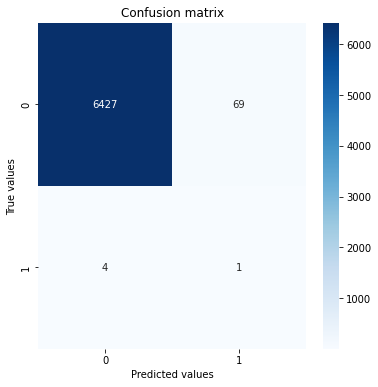

In [5]:
confusion_matrix = metrics.confusion_matrix(true_labels, labels)
vw.plot_confusion_matrix(confusion_matrix)

# ROC curve

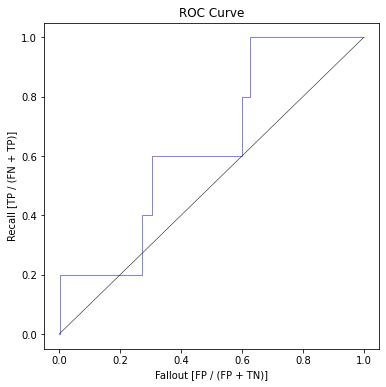

In [6]:
vw.plot_roc_curve(true_labels, scores)

# Precision-recall curve

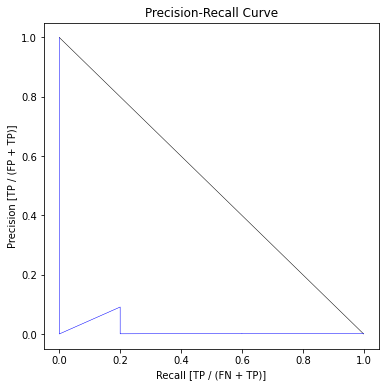

In [7]:
vw.plot_precision_recall_curve(true_labels, scores)

# Assigned labels

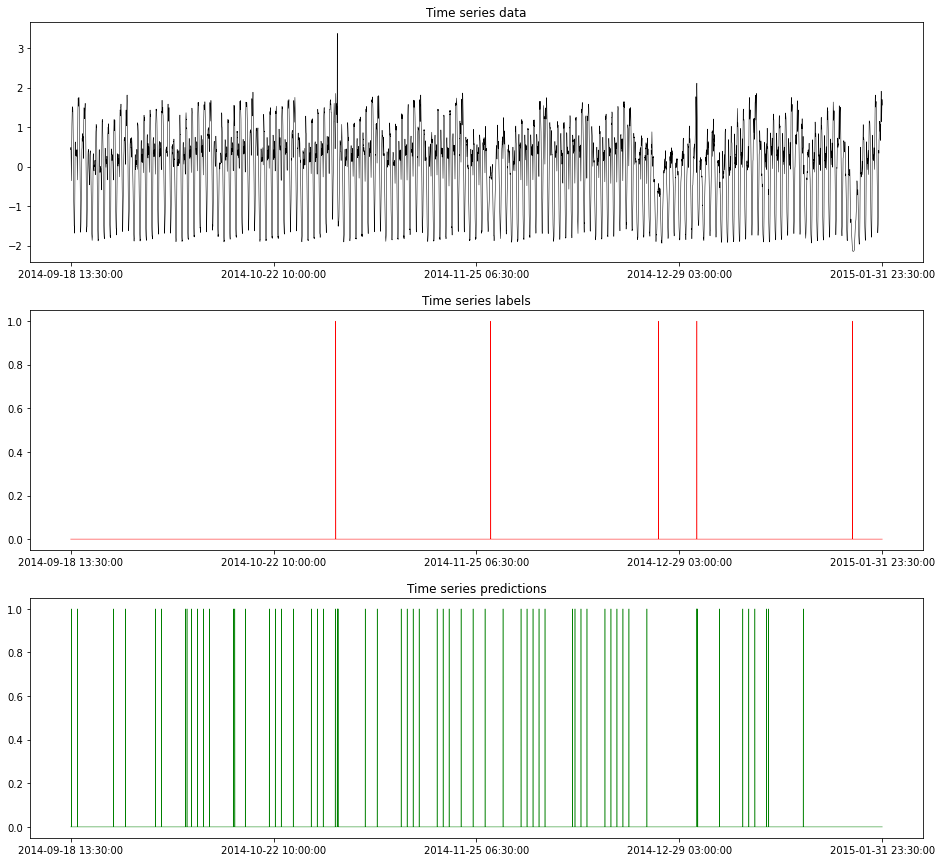

In [8]:
vw.plot_univariate_time_series_predictions(dataframe, labels)

# Assigned scores

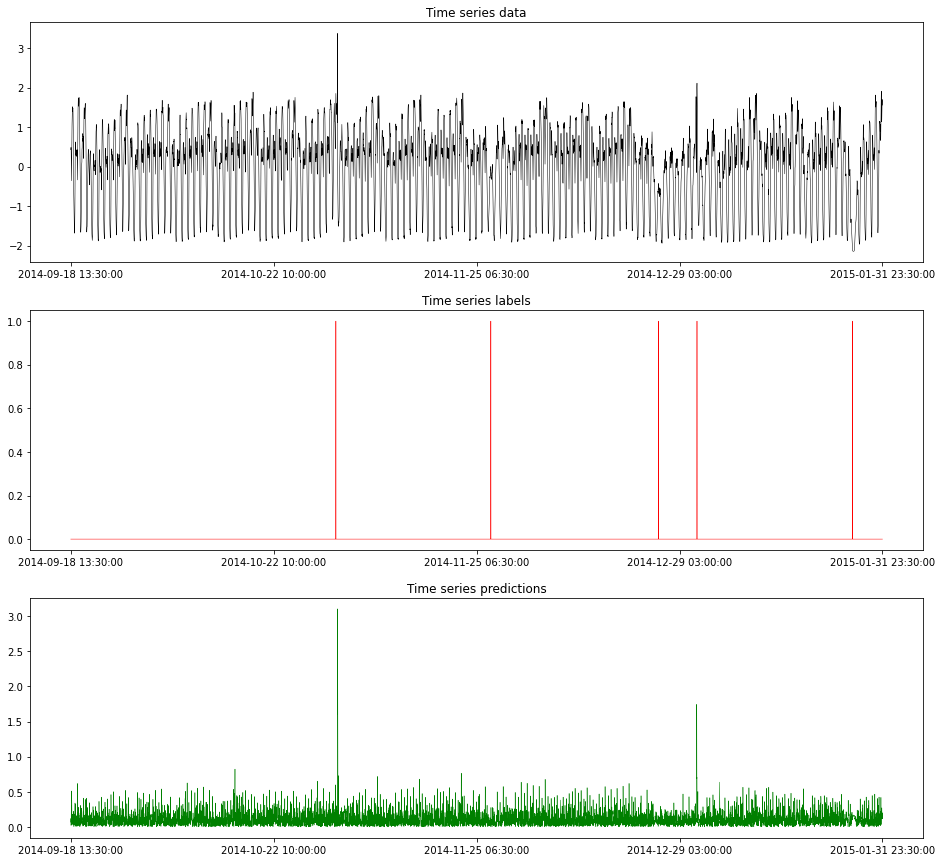

In [9]:
vw.plot_univariate_time_series_predictions(dataframe, scores)

# Anomalies predictions as red dots

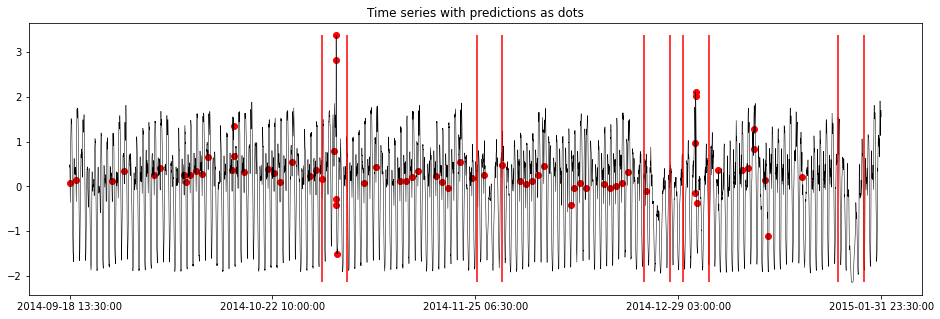

In [10]:
bars = vw.get_bars_indices_on_test_df(all_df,
                                      dataframe,
                                      PURE_DATA_KEY,
                                      GROUND_WINDOWS_PATH)
vw.plot_time_series_with_predicitons_bars(dataframe,
                                          labels,
                                          bars,
                                          pred_color='r')